# QCD estimate from isolation inverted region for muon/electron+jet events

The QCD contamination for lepton plus jet events is estimated based on a sideband region where the the isolation of the lepton has been inverted.  To determine the normalization of the sideband region should be when mapping into the signal region, fake rates are estimated in another sideband region.  Here we carry out a validation of this procedure.

In [1]:
# import and global set up
%cd '/home/naodell/work/wbr/analysis'
%matplotlib notebook
%pwd

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import scripts.plot_tools as pt
pt.set_default_style()

%matplotlib inline
%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 46539,
  "iopub_port": 41477,
  "stdin_port": 48799,
  "control_port": 34537,
  "hb_port": 35437,
  "ip": "127.0.0.1",
  "key": "83980041-5311a5a8419b48be73f83bc0",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-1d42f8b4-7c30-42cc-96f2-38c7057d81dd.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# some initial configuration
selection = 'mutau'
cuts = 'lepton1_pt > 20 and trigger_status == 1'# and n_jets < 2 and n_bjets == 0'
var = 'lepton2_pt'
bins = np.arange(20, 100, 5)

## correction factor from isolation inverted region

In [3]:
# get the anti-iso data
if selection == 'mutau':
    datasets = [
        'muon_2016B_fakes', 'muon_2016C_fakes', 'muon_2016D_fakes',
        'muon_2016E_fakes', 'muon_2016F_fakes', 'muon_2016G_fakes',
        'muon_2016H_fakes'
    ]
elif selection == 'etau':
    datasets = [
        'electron_2016B_fakes', 'electron_2016C_fakes', 'electron_2016D_fakes',
        'electron_2016E_fakes', 'electron_2016F_fakes', 'electron_2016G_fakes',
        'electron_2016H_fakes'
    ]
        
# add MC files for prompt contamination subtraction
datasets += [
    'ttbar_inclusive_fakes',  
    't_tw_fakes', 'tbar_tw_fakes',
    'zjets_m-10to50_alt_fakes', 'zjets_m-50_alt_fakes', 
    'w1jets_fakes', 'w2jets_fakes', 'w3jets_fakes', 'w4jets_fakes'
]

dm = pt.DataManager(input_dir     = f'local_data/flatuples/test/{selection}_2016',
                    dataset_names = datasets,
                    selection     = selection,
                    period        = 2016,
                    scale         = 35.9e3,
                    cuts          = f'{cuts}'
                   )

df_data  = dm.get_dataframe('fakes')
df_ttbar_fakes = dm.get_dataframe('ttbar_fakes')
df_top_fakes   = dm.get_dataframe('t_fakes')
df_z_fakes     = dm.get_dataframe('zjets_fakes')
df_w_fakes     = dm.get_dataframe('wjets_fakes')

df_data_os  = dm.get_dataframe('fakes').query('lepton1_q != lepton2_q')
df_ttbar_os = dm.get_dataframe('ttbar_fakes').query('lepton1_q != lepton2_q')
df_top_os   = dm.get_dataframe('t_fakes').query('lepton1_q != lepton2_q')
df_z_os     = dm.get_dataframe('zjets_fakes').query('lepton1_q != lepton2_q')
df_w_os     = dm.get_dataframe('wjets_fakes').query('lepton1_q != lepton2_q')

df_data_ss  = dm.get_dataframe('fakes').query('lepton1_q == lepton2_q')
df_ttbar_ss = dm.get_dataframe('ttbar_fakes').query('lepton1_q == lepton2_q')
df_top_ss   = dm.get_dataframe('t_fakes').query('lepton1_q == lepton2_q')
df_z_ss     = dm.get_dataframe('zjets_fakes').query('lepton1_q == lepton2_q')
df_w_ss     = dm.get_dataframe('wjets_fakes').query('lepton1_q == lepton2_q')


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


264.42957474533745 259.84634002056305 370.73322001417955
239.73318502034715 132.04963504570003 273.6952796737689


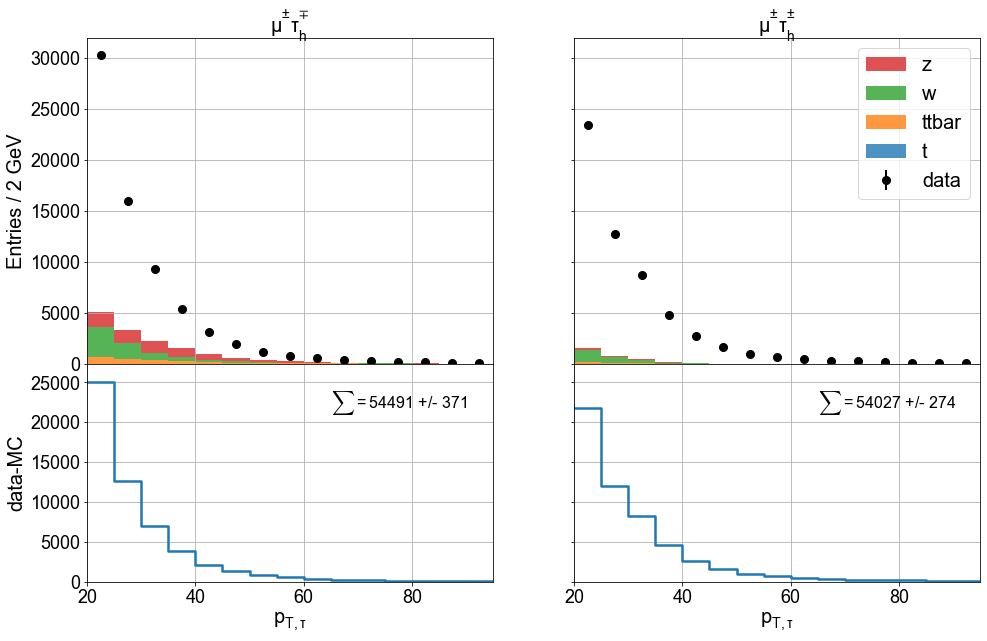

In [4]:
# compare the OS and SS control regions
fig, axes = plt.subplots(2, 2, figsize=(16, 10), facecolor='white', gridspec_kw={'height_ratios':[3,2]}, sharex='col', sharey='row')
fig.subplots_adjust(hspace=0)

ax = axes[0][0]
x, y, yerr = pt.hist_to_errorbar(df_data_os[var], bins = bins)
ax.errorbar(x, y, yerr, fmt='ko', capsize=0, elinewidth=2)
h_mc, _, _ = ax.hist([df_top_os[var], df_ttbar_os[var], df_w_os[var], df_z_os[var]], 
                     bins=bins, 
                     histtype='stepfilled', 
                     alpha=0.8, 
                     weights=[df_top_os['weight'], df_ttbar_os['weight'], df_w_os['weight'], df_z_os['weight']], 
                     stacked=True)
var_mc, _ = np.histogram(np.concatenate([df_top_os[var], df_ttbar_os[var], df_w_os[var], df_z_os[var]]), 
                     bins=bins, 
                     weights=np.concatenate([df_top_os['weight']**2, df_ttbar_os['weight']**2, df_w_os['weight']**2, df_z_os['weight']**2]), 
                     )
err_data, err_mc = np.sqrt(np.sum(yerr**2)), np.sqrt(var_mc.sum())
err_total = np.sqrt(err_data**2 + err_mc**2)
print(err_data, err_mc, err_total)

ax.grid()
ax.set_ylabel('Entries / 2 GeV')
ax.set_xlim(bins.min(), bins.max())
if selection == 'mutau':
    ax.set_title(r'$\mu^{\pm}\tau^{\mp}_{h}$', fontsize=20)
elif selection == 'etau':
    ax.set_title(r'$e^{\pm}\tau^{\mp}_{h}$')
    

ax = axes[1][0]
h_data, _ = np.histogram(df_data_os[var], bins=bins)
diff = y - h_mc[-1]
diff_os_antiiso = np.append(diff, diff[-1])
ax.plot(bins, diff_os_antiiso, drawstyle='steps-post')
ax.text(0.6, 0.8, r'$\sum =$' + f'{diff.sum():.0f} +/- {err_total:.0f}', size = 16, transform = ax.transAxes)
ax.set_ylabel('data-MC')
#ax.set_ylim(0, None)
ax.grid()

ax.set_xlabel(r'$p_{T,\tau}$')
#if selection == 'mutau':
#    ax.set_xlabel('$M_{\mu\tau}$')
#elif selection == 'etau':
#    ax.set_xlabel('$M_{e\tau}$')

ax = axes[0][1]
x, y, yerr = pt.hist_to_errorbar(df_data_ss[var], bins = bins)
eb = ax.errorbar(x, y, yerr, fmt='ko', capsize=0, elinewidth=2)
h_mc, _, _ = ax.hist([df_top_ss[var], df_ttbar_ss[var], df_w_ss[var], df_z_ss[var]], 
                     bins=bins, 
                     histtype='stepfilled', 
                     alpha=0.8, 
                     weights=[df_top_ss['weight'], df_ttbar_ss['weight'], df_w_ss['weight'], df_z_ss['weight']], 
                     stacked=True
                    )

var_mc, _ = np.histogram(np.concatenate([df_top_ss[var], df_ttbar_ss[var], df_w_ss[var], df_z_ss[var]]), 
                     bins=bins, 
                     weights=np.concatenate([df_top_ss['weight']**2, df_ttbar_ss['weight']**2, df_w_ss['weight']**2, df_z_ss['weight']**2]), 
                     )
err_data, err_mc = np.sqrt(np.sum(yerr**2)), np.sqrt(var_mc.sum())
err_total = np.sqrt(err_data**2 + err_mc**2)
print(err_data, err_mc, err_total)

ax.grid()
ax.set_xlim(bins.min(), bins.max())
ax.legend(['z', 'w', 'ttbar', 't', 'data'])
if selection == 'mutau':
    ax.set_title(r'$\mu^{\pm}\tau^{\pm}_{h}$', fontsize=20)
elif selection == 'etau':
    ax.set_title(r'$e^{\pm}\tau^{\pm}_{h}$')

ax = axes[1][1]
diff = y - h_mc[-1]
diff_ss_antiiso = np.append(diff, diff[-1])
ax.plot(bins, diff_ss_antiiso, drawstyle='steps-post')
ax.text(0.6, 0.8, r'$\sum =$' + f'{diff.sum():.0f} +/- {err_total:.0f}', size = 16, transform = ax.transAxes)
ax.set_ylim(0, 1.25*diff.max())
ax.grid()

ax.set_xlabel(r'$p_{T,\tau}$')
#if selection == 'mutau':
#    ax.set_xlabel(r'$M_{\mu\tau}$')
#elif selection == 'etau':
#    ax.set_xlabel(r'$M_{e\tau}$')

#plt.tight_layout()
plt.savefig(f'plots/ltau_fakes/{selection}_cr_antiiso.pdf')
plt.show()

### Calculating the fake background

The mapping from the same-sign control region to the same-sign signal region is done as follows,

$$
N_{OS} = k(N_{SS,data} - N_{SS,bkg})
$$

where $k$ is some scale factor for normalizing the SS data to OS.  The processes that are take from simulation are subtracted from the SS region to avoid double counting.

In [5]:
# N.B.: RUNNING THIS PANEL REPEATEDLY WITHOUT RELOADING THE DATA WILL FUCK SHIT UP YO
# first multiply the weights for the simulated processes by -1
df_ttbar_ss.loc[:,'weight'] *= -1  
df_top_ss.loc[:,'weight'] *= -1  
df_z_ss.loc[:,'weight'] *= -1    
df_w_ss.loc[:,'weight'] *= -1    
#df_vv_ss.loc[:,'weight'] *= -1    

# multiply by k and combine the same-sign data and MC (this should be calculated from the isolation inverted control region)
df_qcd = pd.concat([df_data_ss, df_w_ss, df_ttbar_ss, df_top_ss, df_z_ss], sort=False)
k = diff_os_antiiso.sum()/diff_ss_antiiso.sum()
#df_qcd.loc[:,'weight'] *= k

# relabel fakes
df_qcd['label'] = 'fakes'

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Apply to the isolated signal region

In [6]:
# get the data
# set up and get the data
if selection == 'mutau':
    labels = ['muon']
    cuts = cuts + ' and lepton1_pt > 25'
elif selection == 'etau':
    labels = ['electron']
    cuts = cuts + ' and lepton1_pt > 30'
labels += ['t', 'ttbar', 'wjets', 'zjets_alt']#, 'diboson']

dm = pt.DataManager(input_dir     = f'local_data/flatuples/test/{selection}_2016',
                    dataset_names = [d for l in labels for d in pt.dataset_dict[l]],
                    selection     = selection,
                    period        = 2016,
                    scale         = 35.9e3,
                    cuts          = f'{cuts}'#' and n_bjets == 0  and n_jets < 2'
                                     #and p_miss_zeta - 0.85*p_vis_zeta > -25 \
                                     #and 40 < dilepton1_mass < 100'
                                     #and lepton1_mt < 40 \
                   )
df_data_os  = dm.get_dataframe('data').query('lepton1_q != lepton2_q')
df_ttbar_os = dm.get_dataframe('ttbar').query('lepton1_q != lepton2_q')
df_top_os   = dm.get_dataframe('t').query('lepton1_q != lepton2_q')
df_z_os     = dm.get_dataframe('zjets_alt').query('lepton1_q != lepton2_q')
df_w_os     = dm.get_dataframe('wjets').query('lepton1_q != lepton2_q')
#df_vv_os    = dm.get_dataframe('diboson').query('lepton1_q != lepton2_q')

df_data_ss  = dm.get_dataframe('data').query('lepton1_q == lepton2_q').copy()
df_ttbar_ss = dm.get_dataframe('ttbar').query('lepton1_q == lepton2_q').copy()
df_top_ss   = dm.get_dataframe('t').query('lepton1_q == lepton2_q').copy()
df_z_ss     = dm.get_dataframe('zjets_alt').query('lepton1_q == lepton2_q').copy()
df_w_ss     = dm.get_dataframe('wjets').query('lepton1_q == lepton2_q').copy()
#df_vv_ss    = dm.get_dataframe('diboson').query('lepton1_q == lepton2_q').copy()

753.0650702296582 1470.9089381639653 1652.4769603146192
440.744824132967 778.7585587180793 894.830091568595


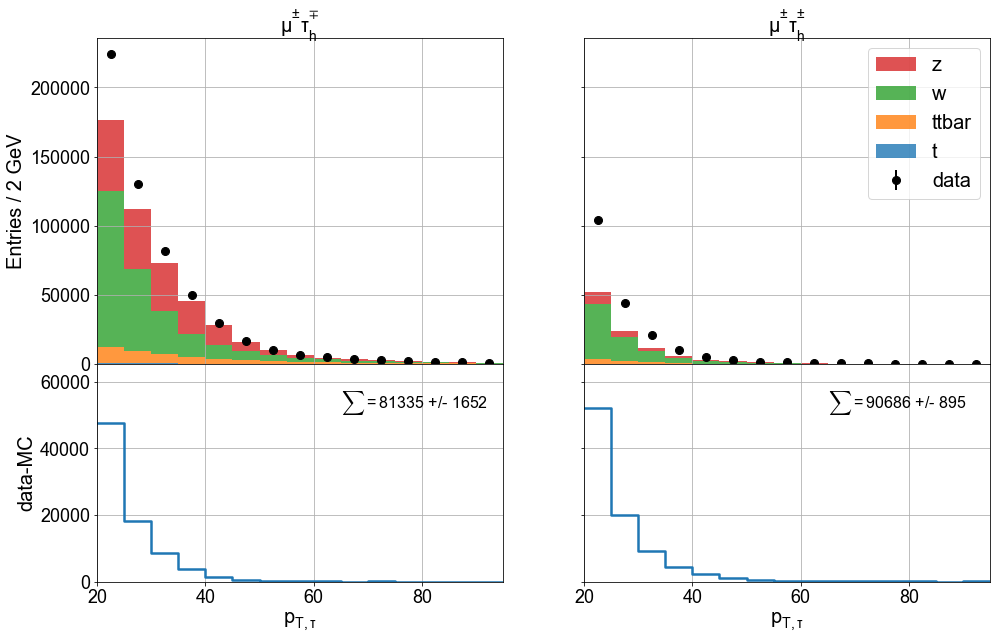

In [7]:
# compare the OS and SS control regions
fig, axes = plt.subplots(2, 2, figsize=(16, 10), facecolor='white', gridspec_kw={'height_ratios':[3,2]}, sharex='col', sharey='row')
fig.subplots_adjust(hspace=0)

ax = axes[0][0]
x, y, yerr = pt.hist_to_errorbar(df_data_os[var], bins = bins)
ax.errorbar(x, y, yerr, fmt='ko', capsize=0, elinewidth=2)
h_mc, _, _ = ax.hist([df_top_os[var], df_ttbar_os[var], df_w_os[var], df_z_os[var]], 
                     bins=bins, 
                     histtype='stepfilled', 
                     alpha=0.8, 
                     weights=[df_top_os['weight'], df_ttbar_os['weight'], df_w_os['weight'], df_z_os['weight']], 
                     stacked=True 
                    )

var_mc, _ = np.histogram(np.concatenate([df_top_os[var], df_ttbar_os[var], df_w_os[var], df_z_os[var]]), 
                     bins=bins, 
                     weights=np.concatenate([df_top_os['weight']**2, df_ttbar_os['weight']**2, df_w_os['weight']**2, df_z_os['weight']**2]), 
                     )
err_data, err_mc = np.sqrt(np.sum(yerr**2)), np.sqrt(var_mc.sum())
err_total = np.sqrt(err_data**2 + err_mc**2)
print(err_data, err_mc, err_total)

ax.grid()
ax.set_ylabel('Entries / 2 GeV')
ax.set_xlim(bins.min(), bins.max())
if selection == 'mutau':
    ax.set_title(r'$\mu^{\pm}\tau^{\mp}_{h}$', fontsize = 20)
elif selection == 'etau':
    ax.set_title(r'$e^{\pm}\tau^{\mp}_{h}$', fontsize = 20)
    

ax = axes[1][0]
h_data, _ = np.histogram(df_data_os[var], bins=bins)
diff = y - h_mc[-1]
diff_os_iso = np.append(diff, diff[-1])
ax.plot(bins, diff_os_iso, drawstyle='steps-post')
ax.text(0.6, 0.8, r'$\sum =$' + f'{diff.sum():.0f} +/- {err_total:.0f}', size = 16, transform = ax.transAxes)
ax.set_ylabel('data-MC')
#ax.set_ylim(0, None)
ax.grid()

ax.set_xlabel(r'$p_{T,\tau}$')
#if selection == 'mutau':
#    ax.set_xlabel('$M_{\mu\mu}$')
#elif selection == 'etau':
#    ax.set_xlabel('$M_{ee}$')

ax = axes[0][1]
x, y, yerr = pt.hist_to_errorbar(df_data_ss[var], bins = bins)
eb = ax.errorbar(x, y, yerr, fmt='ko', capsize=0, elinewidth=2)
h_mc, _, _ = ax.hist([df_top_ss[var], df_ttbar_ss[var], df_w_ss[var], df_z_ss[var]], 
                     bins=bins, 
                     histtype='stepfilled', 
                     alpha=0.8, 
                     weights=[df_top_ss['weight'], df_ttbar_ss['weight'], df_w_ss['weight'], df_z_ss['weight']], 
                     stacked=True
                    )

var_mc, _ = np.histogram(np.concatenate([df_top_ss[var], df_ttbar_ss[var], df_w_ss[var], df_z_ss[var]]), 
                     bins=bins, 
                     weights=np.concatenate([df_top_ss['weight']**2, df_ttbar_ss['weight']**2, df_w_ss['weight']**2, df_z_ss['weight']**2]), 
                     )
err_data, err_mc = np.sqrt(np.sum(yerr**2)), np.sqrt(var_mc.sum())
err_total = np.sqrt(err_data**2 + err_mc**2)
print(err_data, err_mc, err_total)

ax.grid()
ax.set_xlim(bins.min(), bins.max())
ax.legend(['z', 'w', 'ttbar', 't', 'data'])
if selection == 'mutau':
    ax.set_title(r'$\mu^{\pm}\tau^{\pm}_{h}$', fontsize = 20)
    #ax.set_xlabel('$M_{\mu\mu}$')
elif selection == 'etau':
    ax.set_title(r'$e^{\pm}\tau^{\pm}_{h}$', fontsize = 20)
    #ax.set_xlabel('$M_{ee}$')
ax.set_xlabel(r'$p_{T,\tau}$')

ax = axes[1][1]
diff = y - h_mc[-1]
diff_ss_iso = np.append(diff, diff[-1])
ax.plot(bins, diff_ss_iso, drawstyle='steps-post')
ax.text(0.6, 0.8, r'$\sum =$' + f'{diff.sum():.0f} +/- {err_total:.0f}', size = 16, transform = ax.transAxes)
ax.set_ylim(0, 1.25*diff.max())
ax.grid()

ax.set_xlabel(r'$p_{T,\tau}$')
#if selection == 'mutau':
#    ax.set_xlabel('$M_{\mu\tau}$')
#elif selection == 'etau':
#    ax.set_xlabel('$M_{e\tau}$')

#plt.tight_layout()
plt.savefig(f'plots/ltau_fakes/{selection}_cr_iso.pdf')
plt.show()

## Testing the prediction

In [8]:
# N.B.: RUNNING THIS PANEL REPEATEDLY WITHOUT RELOADING THE DATA WILL FUCK SHIT UP YO
# first multiply the weights for the simulated processes by -1
df_ttbar_ss.loc[:,'weight'] *= -1  
df_top_ss.loc[:,'weight'] *= -1  
df_z_ss.loc[:,'weight'] *= -1    
df_w_ss.loc[:,'weight'] *= -1    
#df_vv_ss.loc[:,'weight'] *= -1    

# multiply by k and combine the same-sign data and MC (this should be calculated from the isolation inverted control region)
df_qcd = pd.concat([df_data_ss, df_w_ss, df_ttbar_ss, df_top_ss, df_z_ss], sort=False)
df_qcd.loc[:,'weight'] *= k

# relabel fakes
df_qcd['label'] = 'fakes'

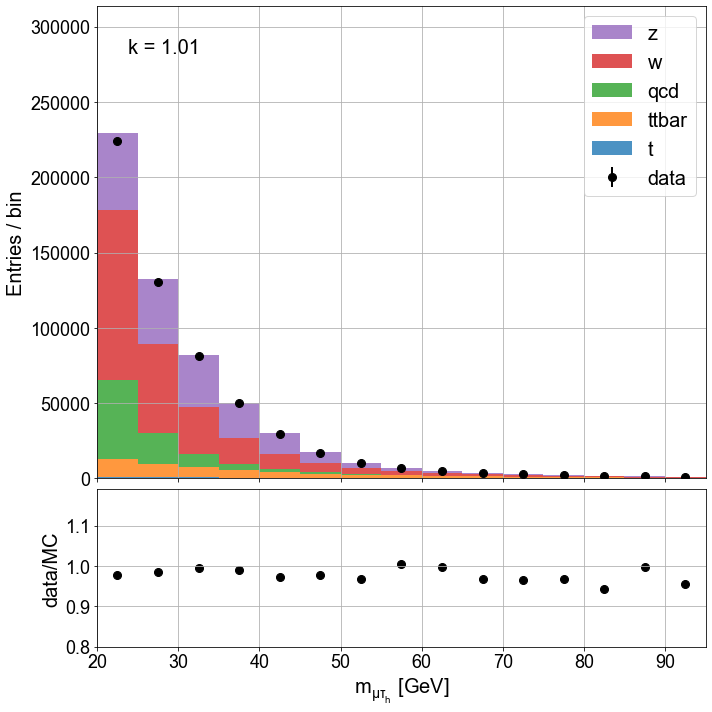

In [9]:
# test the QCD estimate
fig, axes = plt.subplots(2, 1, figsize=(10, 10), facecolor='white', gridspec_kw={'height_ratios':[3,1]}, sharex=True)

ax = axes[0]
x, y, yerr = pt.hist_to_errorbar(df_data_os[var], bins=bins)
eb = ax.errorbar(x, y, yerr, fmt='ko', capsize=0, elinewidth=2)
h_mc, _, _ = ax.hist([df_top_os[var], df_ttbar_os[var], df_qcd[var], df_w_os[var], df_z_os[var]], 
                     bins=bins,
                     histtype='stepfilled', 
                     alpha=0.8, 
                     stacked=True,
                     weights=[df_top_os['weight'], df_ttbar_os['weight'], df_qcd['weight'], df_w_os['weight'], df_z_os['weight']])

ax.legend(['z', 'w', 'qcd', 'ttbar', 't', 'data'])
ax.text(0.05, 0.9, f'k = {k:.2f}', transform = ax.transAxes, fontsize=20)
ax.grid()
ax.set_ylim(0, 1.4*y.max())
ax.set_ylabel(f'Entries / bin')
ax.set_yscale('linear')

ax = axes[1]
r = y/h_mc[-1]
ax.scatter(x, r, marker='o', c='k')
ax.grid()
ax.set_xlim(bins[0], bins[-1])
ax.set_ylim(0.8, 1.19)
#ax.set_xlabel(r'$\sf p_{T,\tau_{h}}$ [GeV]')
if selection == 'mutau':
    ax.set_xlabel(r'$\sf m_{\mu\tau_{h}}$ [GeV]')
elif selection == 'etau':
    ax.set_xlabel(r'$\sf m_{e\tau_{h}}$ [GeV]')
ax.set_ylabel('data/MC')

plt.tight_layout(h_pad=0.)
plt.savefig(f'plots/{selection}_{var}_iso.pdf')
plt.show()

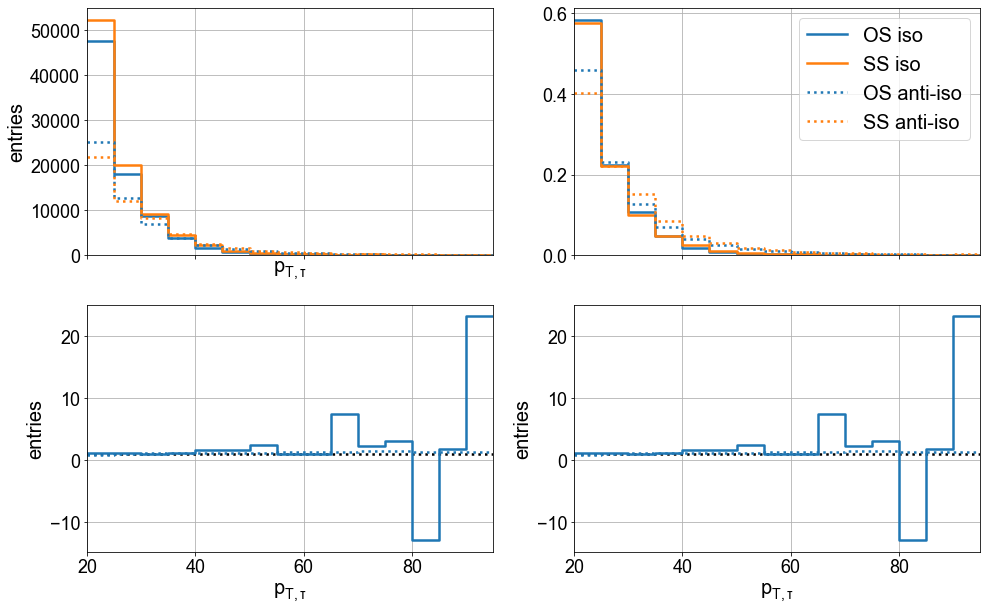

In [10]:
# overlay predictions from OS and SS regions

fig, axes = plt.subplots(2, 2, facecolor='white', figsize=(16, 10), sharex=True)

ax = axes[0][0]
ax.plot(bins, diff_os_iso, drawstyle='steps-post', color='C0', label='OS iso')
ax.plot(bins, diff_ss_iso, drawstyle='steps-post', color='C1', label='SS iso')
ax.plot(bins, diff_os_antiiso, drawstyle='steps-post', color='C0', linestyle=':', label='OS anti-iso')
ax.plot(bins, diff_ss_antiiso, drawstyle='steps-post', color='C1', linestyle=':', label='SS anti-iso')

ax.set_xlim(bins[0], bins[-1])
ax.set_ylabel('entries')
ax.set_ylim(0, 1.05*np.max([diff_os_iso.max(), diff_ss_iso.max(), diff_os_antiiso.max(), diff_ss_antiiso.max()]))
ax.grid()

ax.set_xlabel(r'$p_{T,\tau}$')
#if selection == 'mutau':
#    ax.set_xlabel(r'$M_{\mu\tau}$')
#elif selection == 'etau':
#    ax.set_xlabel(r'$M_{e\tau}$')

ax = axes[1][0]
ax.plot([bins[0], bins[-1]], [1, 1], 'k:', label='_nolegend_')
ax.plot(bins, diff_ss_iso/diff_os_iso, drawstyle='steps-post', color='C0', label='OS iso')
ax.plot(bins, diff_ss_antiiso/diff_os_antiiso, drawstyle='steps-post', color='C0', linestyle=':', label='OS anti-iso')

ax.set_xlim(bins[0], bins[-1])
ax.set_ylabel('entries')
ax.set_xlabel(r'$p_{T,\tau}$')
ax.grid()

ax = axes[0][1]
ax.plot(bins, diff_os_iso/diff_os_iso.sum(), drawstyle='steps-post', color='C0', label='OS iso')
ax.plot(bins, diff_ss_iso/diff_ss_iso.sum(), drawstyle='steps-post', color='C1', label='SS iso')
ax.plot(bins, diff_os_antiiso/diff_os_antiiso.sum(), drawstyle='steps-post', color='C0', linestyle=':', label='OS anti-iso')
ax.plot(bins, diff_ss_antiiso/diff_ss_antiiso.sum(), drawstyle='steps-post', color='C1', linestyle=':', label='SS anti-iso')
ax.set_ylim(0, None)
ax.legend()
ax.grid()

ax = axes[1][1]
ax.plot([bins[0], bins[-1]], [1, 1], 'k:', label='_nolegend_')
ax.plot(bins, diff_ss_iso/diff_os_iso, drawstyle='steps-post', color='C0', label='iso')
ax.plot(bins, diff_ss_antiiso/diff_os_antiiso, drawstyle='steps-post', color='C0', linestyle=':', label='anti-iso')

ax.set_xlim(bins[0], bins[-1])
ax.set_ylabel('entries')
ax.set_xlabel(r'$p_{T,\tau}$')
ax.grid()

ax.set_xlabel(r'$p_{T,\tau}$')
#if selection == 'mutau':
#    ax.set_xlabel(r'$M_{\mu\tau}$')
#elif selection == 'etau':
#    ax.set_xlabel(r'$M_{e\tau}$')

#plt.tight_layout()
plt.savefig(f'plots/ltau_fakes/{selection}_fake_comparison.pdf')
plt.show()

In [11]:
# N.B.: RUNNING THIS PANEL REPEATEDLY WITHOUT RELOADING THE DATA WILL FUCK SHIT UP YO
# first multiply the weights for the simulated processes by -1
df_ttbar_ss.loc[:,'weight'] *= -1  
df_top_ss.loc[:,'weight'] *= -1  
df_z_ss.loc[:,'weight'] *= -1    
df_w_ss.loc[:,'weight'] *= -1    
#df_vv_ss.loc[:,'weight'] *= -1    

# multiply by k and combine the same-sign data and MC (this should be calculated from the isolation inverted control region)
k = diff_os_iso.sum()/diff_ss_iso.sum()
df_qcd = pd.concat([df_data_ss, df_w_ss, df_ttbar_ss, df_top_ss, df_z_ss], sort=False)
#df_qcd.loc[:,'weight'] *= k

# relabel fakes
df_qcd['label'] = 'fakes'